# Statistics on Logistic Regression

We will arange data and train LogisticRegression classifier on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Classifier

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0.036464497748678756
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.0321798749747933


In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [4]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

## Logistic Regression

This one is pretty powerful and again with data scaled should work excelently. This is expected to bring the best results.

We will look at penalty function (norm), regularization strength (C param), intercept_scaling (the constant added to class calc, should play with this a little), max_iter and tol (tolerance for stopping).

In [5]:
from sklearn.linear_model import LogisticRegression

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.3, 1.5]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5]
max_iters = [3, 10, 20, 100]
tols = [0.00007, 0.0001, 0.0005]

lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

In [6]:
laccuracies = list(map(run_model, lmodels))

In [7]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(lmodels, laccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.penalty, model.intercept_scaling, model.max_iter, model.tol, sn, acc))

lresults = DataFrame(data, columns=('C', 'penalty', 'intercept_scaling', 'max_iter', 'tol', 'stock', 'accuracy'))

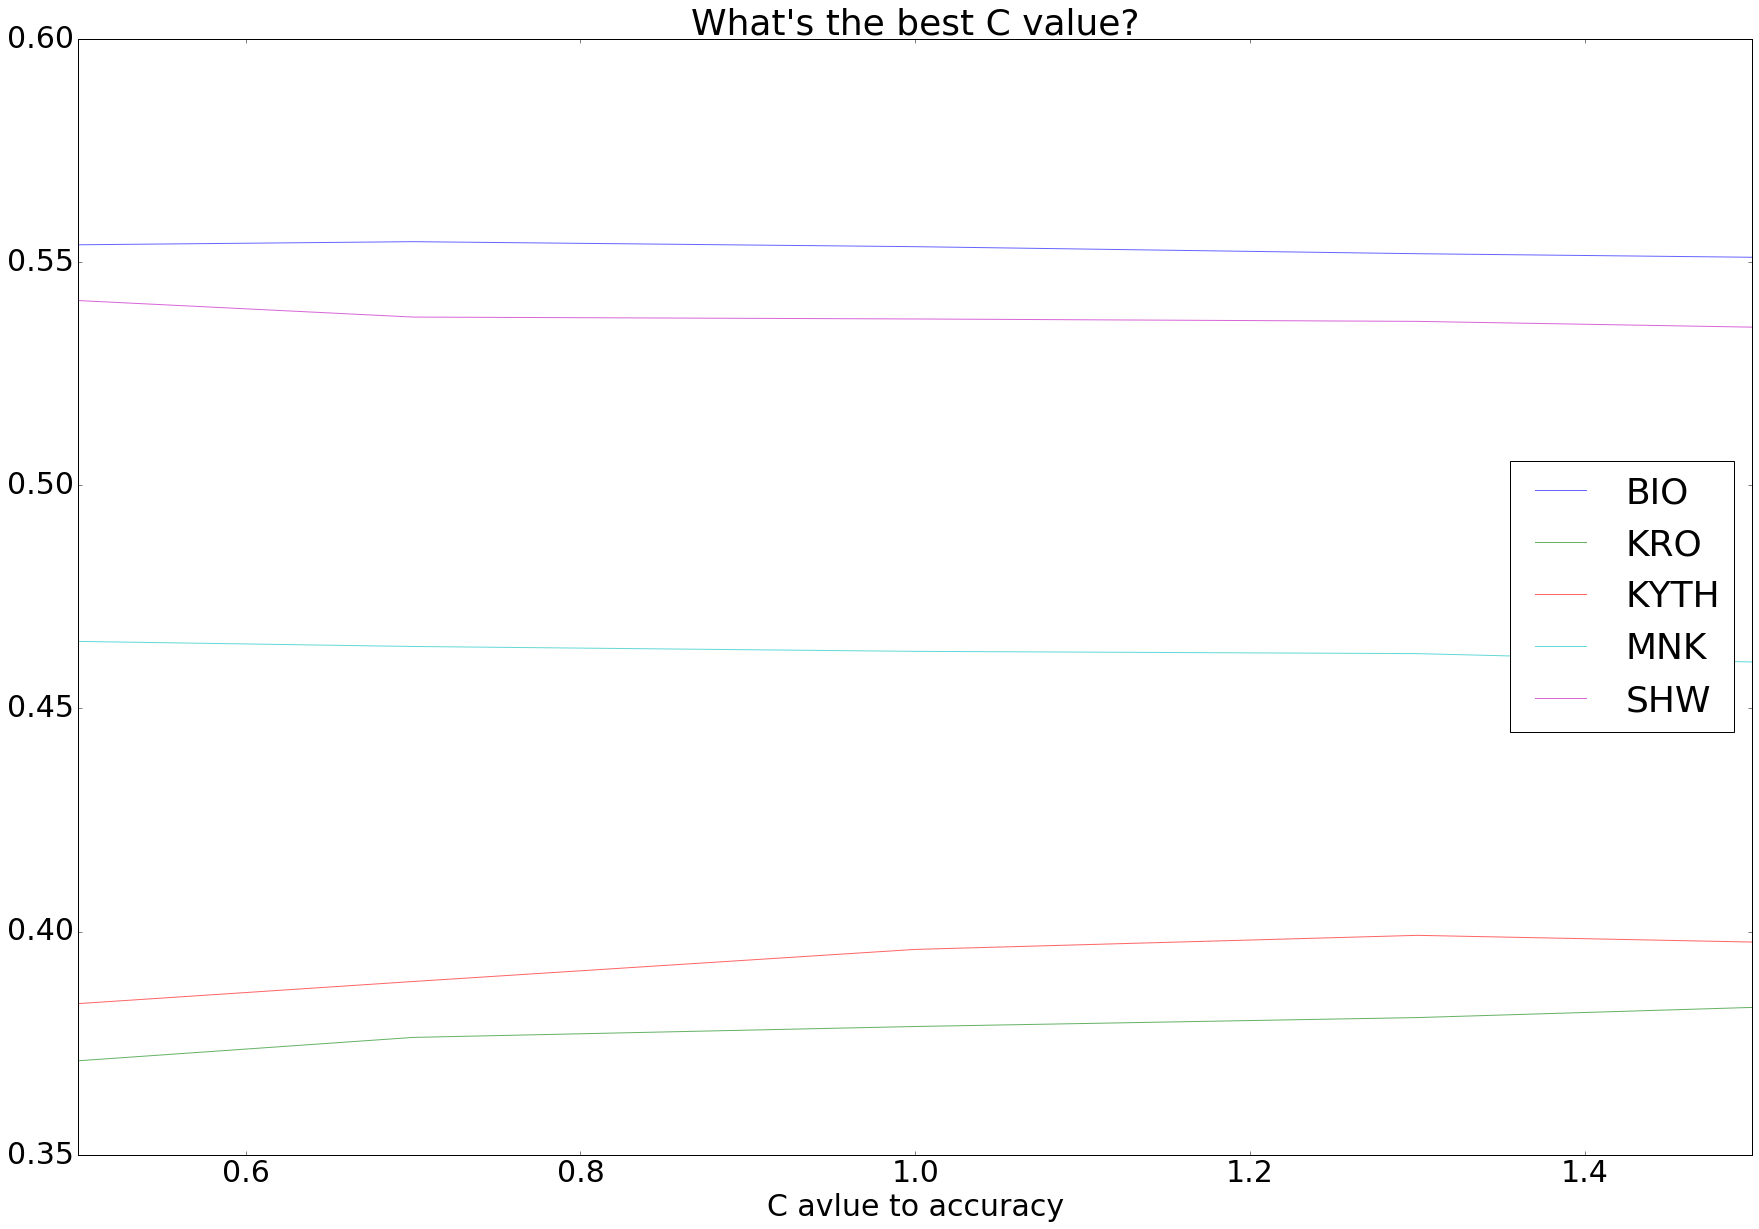

In [8]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

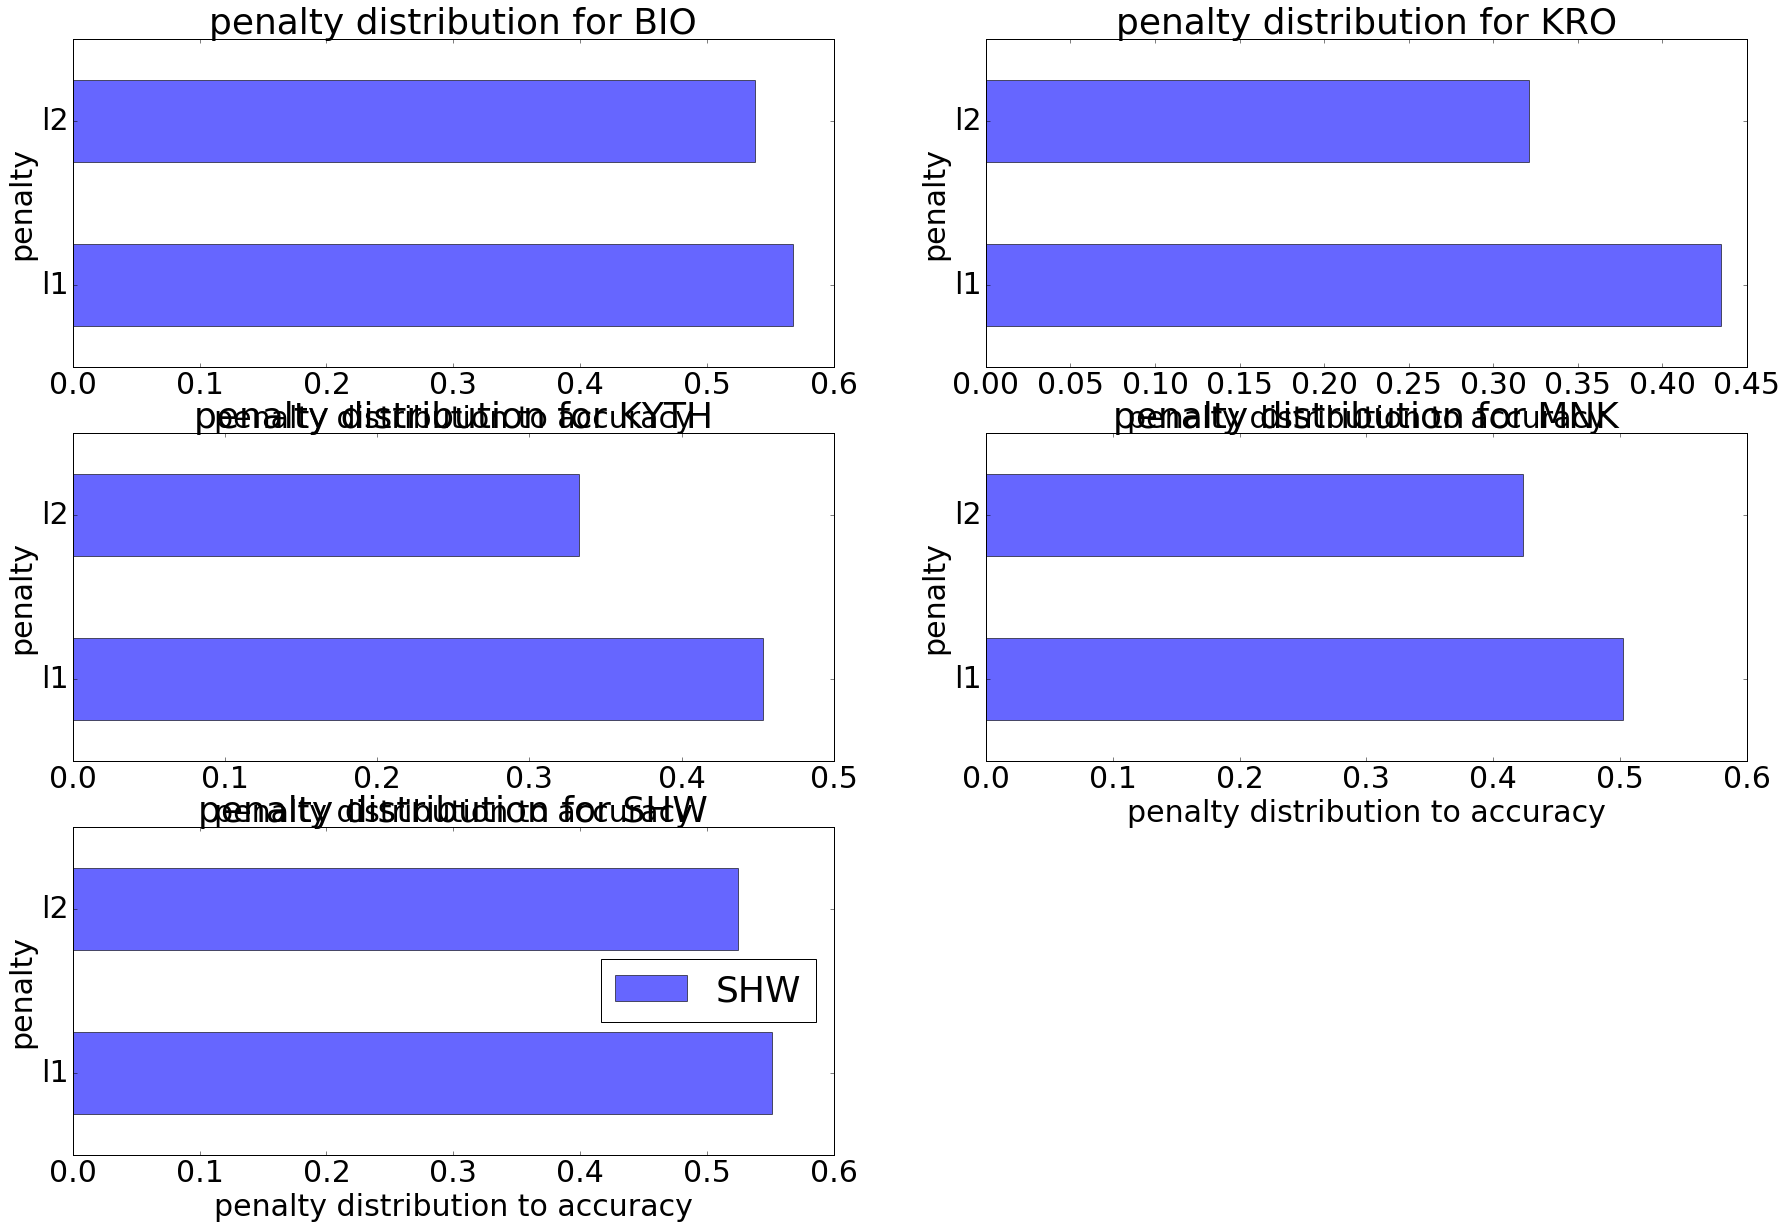

In [9]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(lresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('penalty').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution to accuracy')
    ax1.set_title("penalty distribution for {}".format(name))
plt.legend(loc='best')


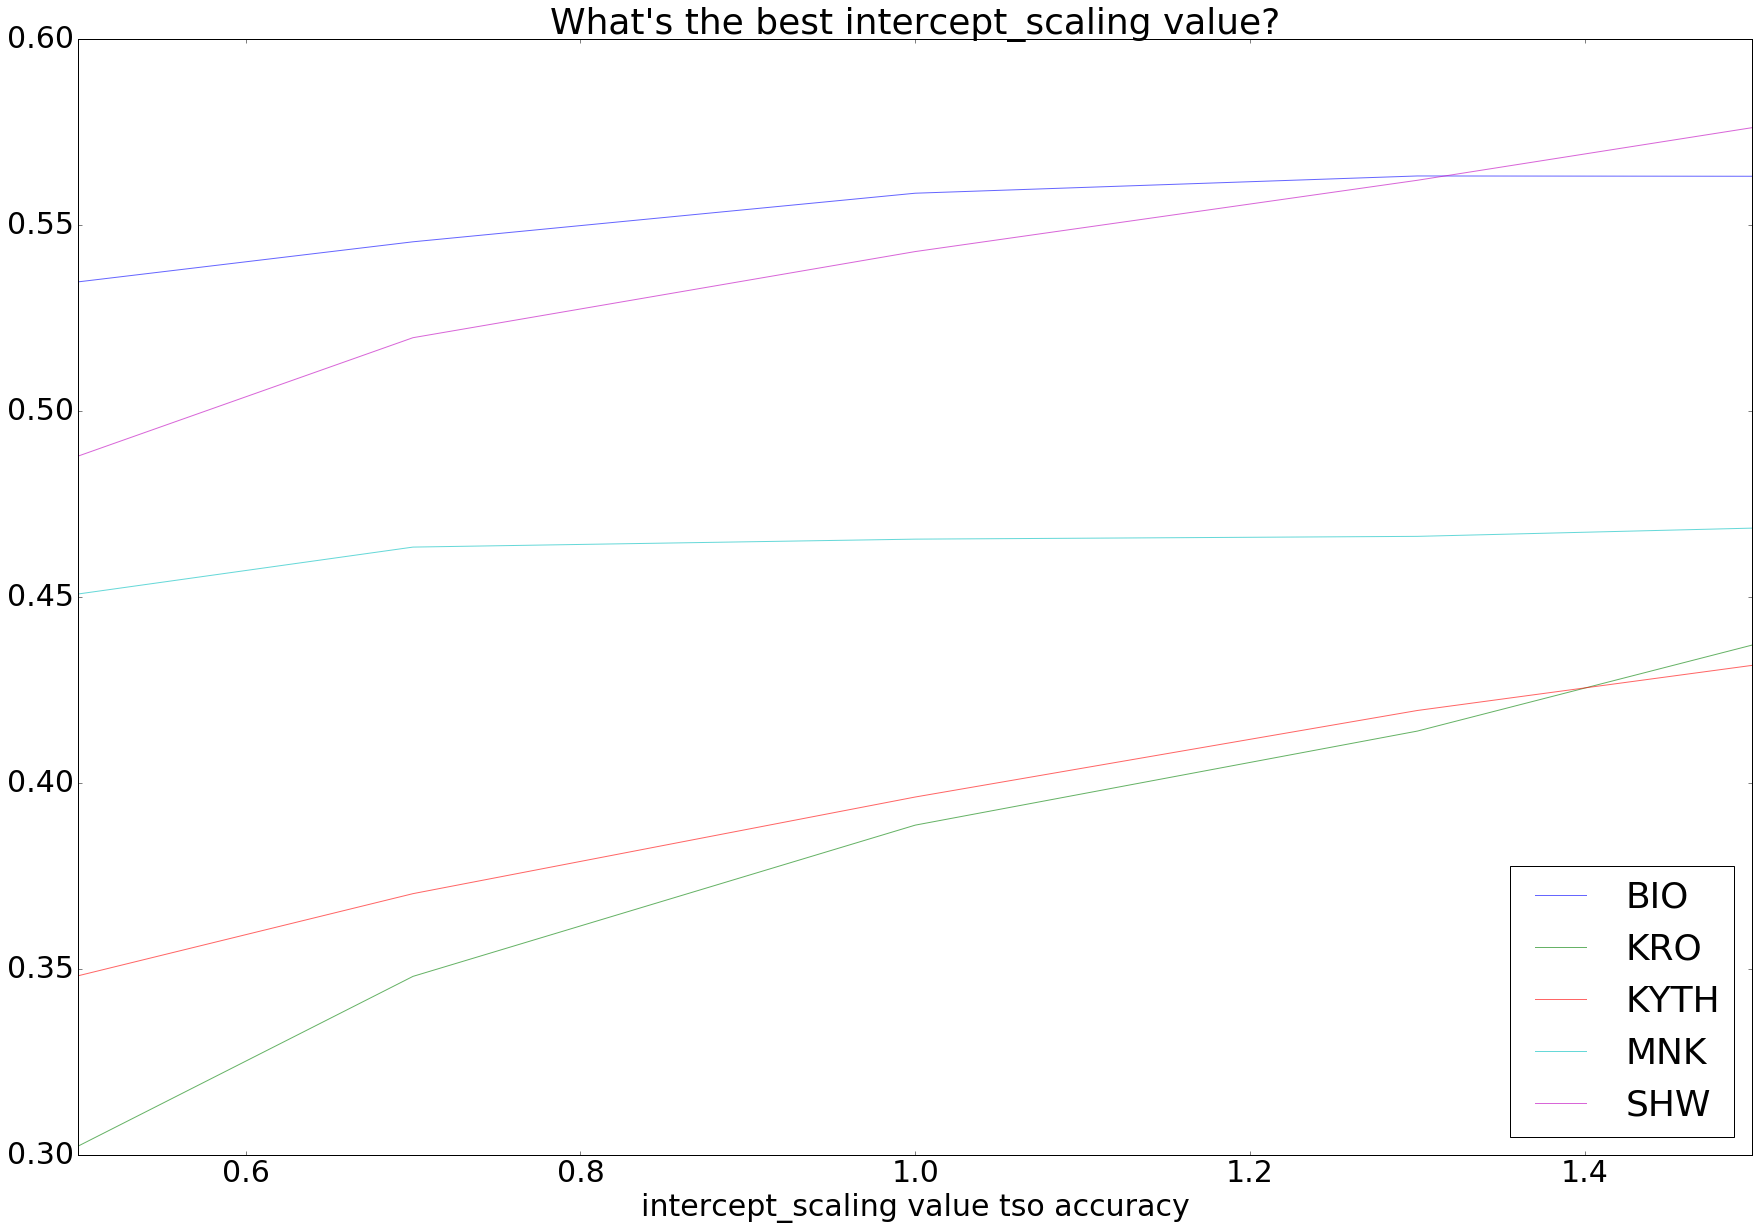

In [10]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value tso accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

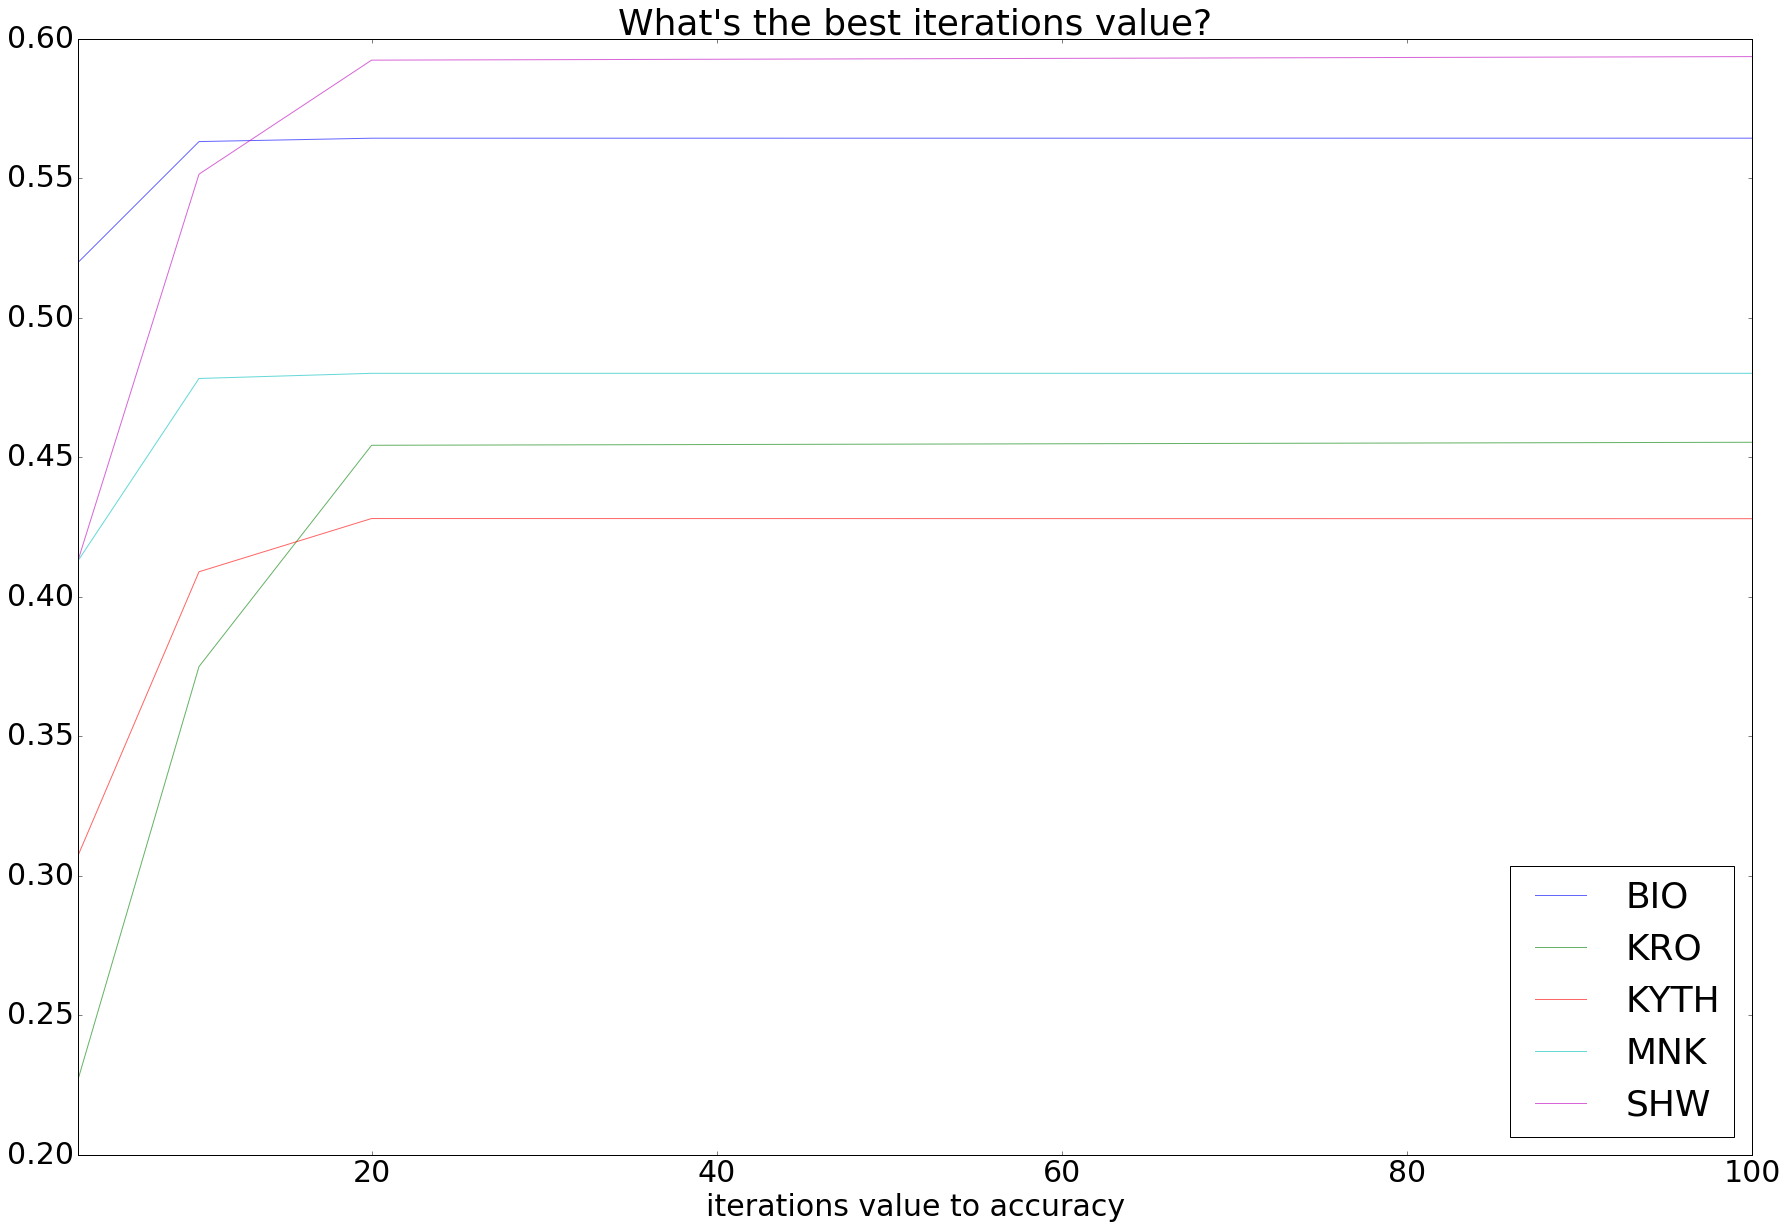

In [11]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('iterations value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best iterations value?" )

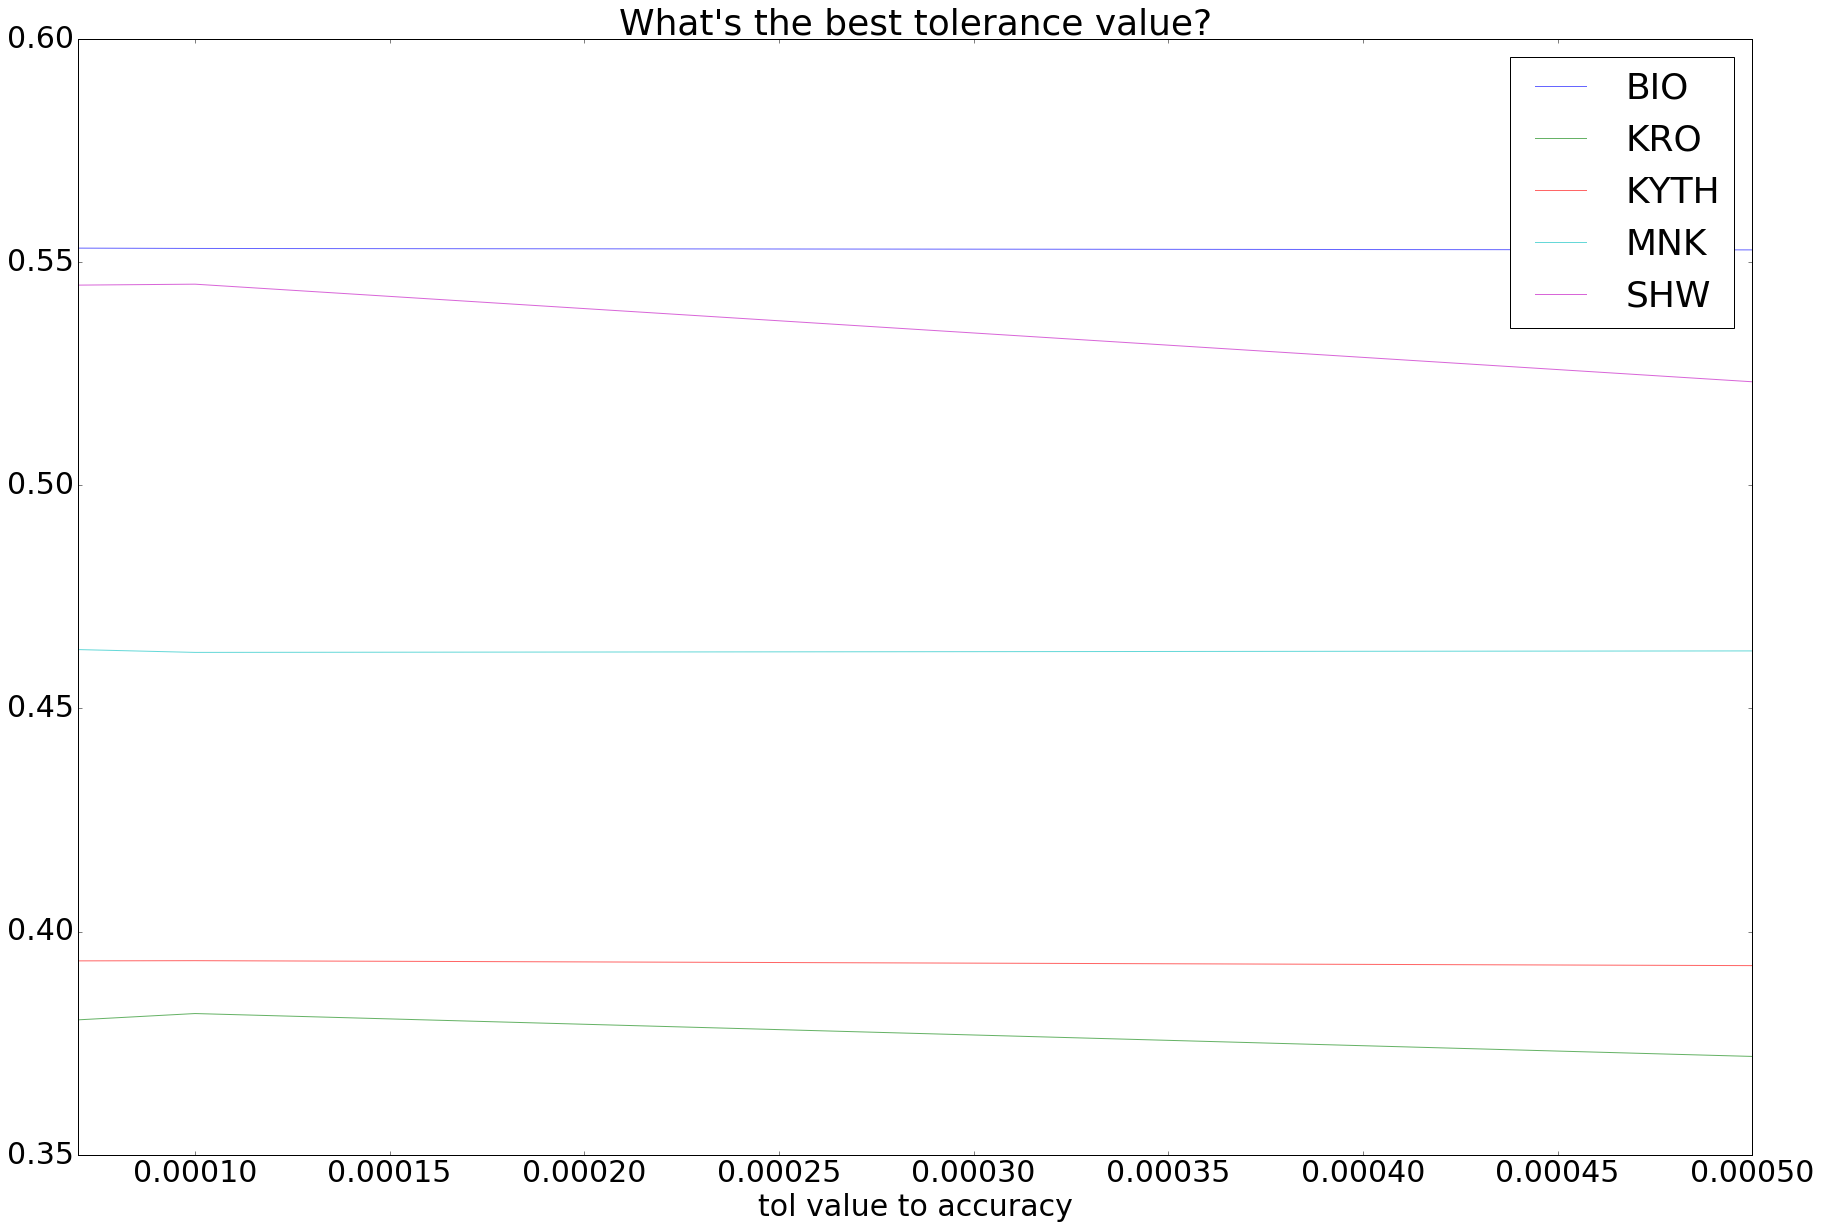

In [12]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('tol').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('tol value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best tolerance value?" )

In [13]:
print(get_best_model(lmodels, laccuracies))
print(get_best_median_model(lmodels, laccuracies))

(2.9244388844941951, LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.5, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
(0.58410298421645279, LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.3, max_iter=20, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))


Well this sucks.